# Requirements

In [1]:
! pip install numpy pandas torch scikit-learn yfinance matplotlib seaborn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


# Data Preparation

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Define the ticker symbol
ticker_symbol = "AAPL"

# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)

# Fetch historical market data
historical_data = ticker.history(start='1981-04-22', end='2024-12-11', interval='1d')
historical_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1981-04-22 00:00:00-05:00,0.097975,0.098405,0.097975,0.097975,18995200,0.0,0.0
1981-04-23 00:00:00-05:00,0.100553,0.100983,0.100553,0.100553,58016000,0.0,0.0
1981-04-24 00:00:00-05:00,0.100553,0.100553,0.099694,0.099694,35056000,0.0,0.0
1981-04-27 00:00:00-04:00,0.099264,0.099264,0.098834,0.098834,38528000,0.0,0.0
1981-04-28 00:00:00-04:00,0.097545,0.097545,0.097116,0.097116,32188800,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-04 00:00:00-05:00,242.869995,244.110001,241.250000,243.009995,44383900,0.0,0.0
2024-12-05 00:00:00-05:00,243.990005,244.539993,242.130005,243.039993,40033900,0.0,0.0
2024-12-06 00:00:00-05:00,242.910004,244.630005,242.080002,242.839996,36870600,0.0,0.0


In [4]:
# Feature Engineering
df = historical_data.copy()
df['Return'] = df['Close'].pct_change()
df['Volume Change'] = df['Volume'] - df['Volume'].shift(1)
df['MA_3'] = df['Close'].rolling(window=3).mean()
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_14'] = df['Close'].rolling(window=14).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()
df['MA_90'] = df['Close'].rolling(window=90).mean()
df['MA_Signal_1_3'] = df['Close'] - df['MA_3']
df['MA_Signal_3_7'] = df['MA_3'] - df['MA_7']
df['MA_Signal_7_14'] = df['MA_7'] - df['MA_14']
df['MA_Signal_14_30'] = df['MA_14'] - df['MA_30']
df['MA_Signal_30_90'] = df['MA_30'] - df['MA_90']
df['MA_Factor_1_3'] = df['MA_Signal_1_3'] / df['MA_3']
df['MA_Factor_3_7'] = df['MA_Signal_3_7'] / df['MA_7']
df['MA_Factor_7_14'] = df['MA_Signal_7_14'] / df['MA_14']
df['MA_Factor_14_30'] = df['MA_Signal_14_30'] / df['MA_30']
df['MA_Factor_30_90'] = df['MA_Signal_30_90'] / df['MA_90']
df = df[[# 'MA_3', 'MA_7', 'MA_14', 'MA_30',
        # 'MA_Signal_1_3', 'MA_Signal_3_7', 'MA_Signal_7_14', 'MA_Signal_14_30',
        'MA_Factor_1_3', 'MA_Factor_3_7', 'MA_Factor_7_14', 'MA_Factor_14_30', 'MA_Factor_30_90',
        # 'Close', 'High', 'Low',
        # 'Volume', 'Volume Change',
        'Return']].dropna()

TARGET_VAL = 'Return'

In [5]:
df.head()

,MA_Factor_1_3,MA_Factor_3_7,MA_Factor_7_14,MA_Factor_14_30,MA_Factor_30_90,Return
Date,,,,,,
1981-08-27 00:00:00-04:00,-0.002178,-0.038232,-0.079589,-0.066398,-0.137856,0.006578
1981-08-28 00:00:00-04:00,0.036486,-0.016879,-0.072148,-0.074534,-0.142013,0.052297
1981-08-31 00:00:00-04:00,0.016845,0.013102,-0.068540,-0.082804,-0.143749,0.000000
1981-09-01 00:00:00-04:00,0.040565,0.041971,-0.051547,-0.087512,-0.144310,0.062108
1981-09-02 00:00:00-04:00,0.031619,0.047619,-0.026770,-0.091052,-0.142902,0.017543


In [6]:
df.describe()

,MA_Factor_1_3,MA_Factor_3_7,MA_Factor_7_14,MA_Factor_14_30,MA_Factor_30_90,Return
count,10913.000000,10913.000000,10913.000000,10913.000000,10913.000000,10913.000000
mean,0.000801,0.001539,0.002596,0.005922,0.023167,0.001145
std,0.020915,0.024656,0.030149,0.047707,0.108125,0.027682
min,-0.397368,-0.396722,-0.399380,-0.458225,-0.514995,-0.518692
25%,-0.009219,-0.010931,-0.013604,-0.020023,-0.032998,-0.012499
50%,0.000950,0.001758,0.003365,0.008079,0.031790,0.000053
75%,0.010823,0.014359,0.019936,0.035022,0.091950,0.014304
max,0.199431,0.211751,0.176027,0.198848,0.377530,0.332281


<Axes: xlabel='Date'>

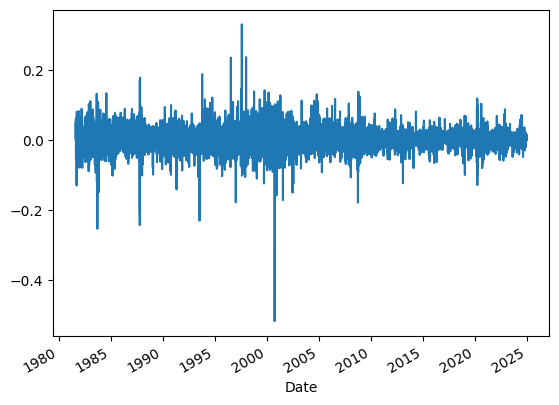

In [7]:
df.Return.plot()

<Axes: xlabel='Date'>

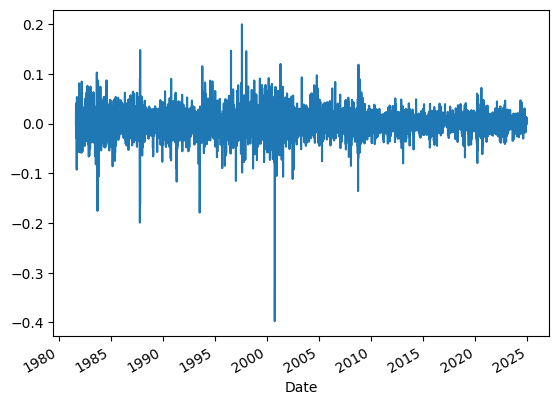

In [8]:
df.MA_Factor_1_3.plot()

<Axes: xlabel='Date'>

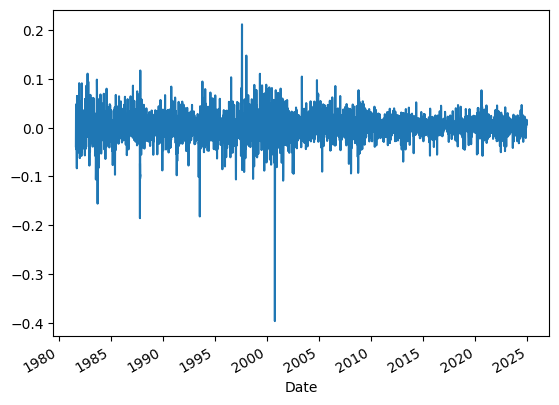

In [9]:
df.MA_Factor_3_7.plot()

<Axes: xlabel='Date'>

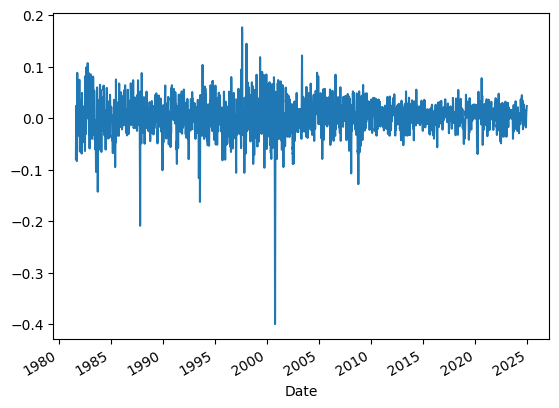

In [10]:
df.MA_Factor_7_14.plot()

In [11]:
df_over_time = df.copy()

for i in range(1, 8):
  df_over_time[f'MA_Factor_1_3_D{i}'] = df_over_time['MA_Factor_1_3'].shift(i)
  df_over_time[f'MA_Factor_3_7_D{i}'] = df_over_time['MA_Factor_3_7'].shift(i)
  df_over_time[f'MA_Factor_7_14_D{i}'] = df_over_time['MA_Factor_7_14'].shift(i)
  df_over_time[f'Return_D{i}'] = df_over_time['Return'].shift(i)

df_over_time = df_over_time.dropna()

In [12]:
df_over_time.drop(columns=[col for col in df_over_time.columns if col.startswith('MA') and len(col.split('_'))==4])\
            .corr()['Return']\
            .sort_values(key=abs, ascending=False)

Return               1.000000
MA_Factor_1_3_D2    -0.036951
Return_D3           -0.032776
MA_Factor_1_3_D4     0.027770
Return_D4            0.027119
Return_D2           -0.026545
MA_Factor_7_14_D7    0.021142
MA_Factor_7_14_D6    0.018906
MA_Factor_1_3_D3    -0.015621
MA_Factor_7_14_D5    0.012730
MA_Factor_3_7_D3     0.012721
MA_Factor_3_7_D6    -0.012082
MA_Factor_3_7_D1    -0.011534
MA_Factor_3_7_D4     0.011395
Return_D1            0.010868
MA_Factor_3_7_D7    -0.010269
MA_Factor_1_3_D5     0.009209
Return_D6            0.008380
MA_Factor_1_3_D6     0.008186
MA_Factor_7_14_D4    0.007821
Return_D5            0.005859
MA_Factor_7_14_D3    0.005367
MA_Factor_3_7_D2     0.005284
MA_Factor_3_7_D5    -0.003906
MA_Factor_1_3_D7    -0.001965
MA_Factor_7_14_D2    0.001588
MA_Factor_1_3_D1    -0.000791
Return_D7            0.000398
MA_Factor_7_14_D1   -0.000390
Name: Return, dtype: float64

In [13]:
# Splitting the data
df_train = df[:-730]
df_test = df[-730:-365]
df_backtest_train = pd.concat([df_train, df_test])
df_backtest_test = df[-365:]

In [14]:
print('Training Period:', df_train.index.min(), df_train.index.max())
print('Validation Period:', df_test.index.min(), df_test.index.max())
print('Backtest Period:', df_backtest_test.index.min(), df_backtest_test.index.max())

Training Period: 1981-08-27 00:00:00-04:00 2022-01-13 00:00:00-05:00
Validation Period: 2022-01-14 00:00:00-05:00 2023-06-29 00:00:00-04:00
Backtest Period: 2023-06-30 00:00:00-04:00 2024-12-10 00:00:00-05:00


In [15]:
def make_sequences(obs_x, obs_y, sequence_len=7, n_features=1, predicted_index=-1):
    x = []
    y = []
    for i in range(len(obs_x) - sequence_len):
        window = obs_x[i:(i + sequence_len)]
        after_window = obs_y[i + sequence_len]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, sequence_len, n_features), torch.tensor(y, dtype=torch.float32).view(-1, 1)
    

def prepare_data(df_train, df_test, target_val, sequence_len=7, batch_size=32):
    # Scaling the features
    scaler = StandardScaler()
    
    n_features = df_train.shape[1]
    
    df_train_scaled = scaler.fit_transform(df_train)
    y_train = df_train[[target_val]].to_numpy().reshape(-1, 1)
    
    df_test_scaled = scaler.transform(df_test)
    y_test = df_test[[target_val]].to_numpy().reshape(-1, 1)
    
    # Make sequences
    x_train, y_train = make_sequences(df_train_scaled, y_train, sequence_len, n_features=df_train_scaled.shape[1])
    x_test, y_test = make_sequences(df_test_scaled, y_test, sequence_len, n_features=df_test_scaled.shape[1])
    
    # Setup data loaders for batch
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    
    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Neural Nets



In [16]:
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [18]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, n_encoder_layers=2, dropout=0.2):
        super().__init__()
        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_encoder_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

In [19]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim=1, d_model=64, lstm_hidden_size=8, n_lstm_layers=1, dropout=0.2):
        super().__init__()
        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.lstm = nn.LSTM(d_model, hidden_size=lstm_hidden_size, num_layers=n_lstm_layers)
        self.linear = nn.Linear(lstm_hidden_size, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x, _ = self.lstm(x)
        x = self.linear(x[:,-1,:])
        return x

In [20]:
class ModelTrainer:
    def __init__(self, model,
                 criterion=nn.MSELoss(),
                 optimizer_class=torch.optim.Adam,
                 lr=0.001,
                 lr_reduce_factor=0.5,
                 lr_reduce_patience=3):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer_class(model.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', factor=0.5, patience=3, verbose=True)

    def train(self, train_loader, test_loader, epochs = 1000, early_stop_threshold=5, buy_threshold=0.005):
        early_stop_count = 0
        min_val_loss = float('inf')

        for epoch in range(epochs):
            model.train()
            for batch in train_loader:
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                self.optimizer.zero_grad()
                outputs = model(x_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()

            # Validation
            model.eval()
            val_losses = []
            init_amt = 100
            amt = init_amt
            with torch.no_grad():
                for batch in test_loader:
                    x_batch, y_batch = batch
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    outputs = model(x_batch)
                    loss = self.criterion(outputs, y_batch)
                    val_losses.append(loss.item())

                    for i, p in enumerate(outputs.squeeze().tolist()):
                      if p > buy_threshold:
                        amt *= (1+y_batch[i])

            val_loss = np.mean(val_losses)
            self.scheduler.step(val_loss)

            if val_loss < min_val_loss:
                min_val_loss = val_loss
                early_stop_count = 0
            else:
                early_stop_count += 1

            if early_stop_count >= early_stop_threshold:
                print("Early stopping!")
                break
            print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.9f},", f'Return: {round(float(amt), 2)}$')

        return min_val_loss

# Training

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns
import datetime as dt

In [22]:
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [23]:
torch.manual_seed(0)

In [24]:
def plot_simulation(title, prices, events_list):
    plt.figure(figsize=(15,5))
    plt.plot(prices)

    y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
    shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

    for idx, event in enumerate(events_list):
        plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
        if event[0] == 's':
            color = 'green' if event[2] > 0 else 'red'
            plt.fill_betweenx(range(*shaded_y_lims),
                              event[1], events_list[idx-1][1], color=color, alpha=0.1)

    plt.title(title)
    plt.ylim(*y_lims)
    plt.show()


def simulate(model, test_loader, df_test, prices, ticker_symbol, thresh=0, sequence_len=7):
    prices = prices[df_test.index.min():df_test.index.max()]

    predictions = []
    y_test = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            predictions.extend(outputs.squeeze().tolist())
            y_test.extend(y_batch.squeeze().tolist())

    predictions = np.array(predictions)
    y_test = np.array(y_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    accuracy = accuracy_score(y_test > 0, predictions > 0)
    recall = recall_score(y_test > 0, predictions > 0)
    precision = precision_score(y_test > 0, predictions > 0)
    f1 = f1_score(y_test > 0, predictions > 0)
    
    init_amt = 100
    amt = init_amt
    amt_holding_start = None
    holding = False
    events_list = []
    buy_and_hold_return = init_amt
    
    for i, p in enumerate(predictions):
        next_day_idx = i + sequence_len
        today_idx = next_day_idx - 1
        
        if (p > thresh) and not holding:
            events_list.append(('b', df_test.index[today_idx], None))
            holding = True
            amt_holding_start = amt
        elif (p <= thresh) and holding:
            events_list.append(('s', df_test.index[today_idx], amt - amt_holding_start))
            holding = False

        if holding:
            amt *= 1 + df_test.iloc[next_day_idx]['Return']

        buy_and_hold_return *= 1 + df_test.iloc[next_day_idx]['Return']

    if events_list[-1][0] == 'b':
        final_date = df_test.index[-1] + dt.timedelta(days=1)
        events_list.append(('s', final_date, amt - amt_holding_start))

    title = f'{ticker_symbol} Price Data'
    title += f'\nThresh = {thresh} Return: {round(amt.item(),2)}%, Baseline Return (Buy & Hold): {round(buy_and_hold_return, 2)}%'
    title += f'\nRMSE: {round(rmse, 6)}, R2: {round(r2, 2)}, Direction Accuracy: {round(accuracy,2)*100}%'
    title += f'\nF1-Score: {round(f1,2)}, Recall: {round(recall,2)}, Precision: {round(precision,2)}'

    plot_simulation(title, prices, events_list)

## LSTM

In [25]:
train_loader, test_loader = prepare_data(df_train, df_test, 'Return')

/tmp/ipykernel_477384/510213348.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(x, dtype=torch.float32).view(-1, sequence_len, n_features), torch.tensor(y, dtype=torch.float32).view(-1, 1)


In [26]:
model = LSTMRegressor(input_dim=6, d_model=8, lstm_hidden_size=4, n_lstm_layers=1, dropout=0.1).to(device)
trainer = ModelTrainer(model, lr=0.001)
trainer.train(train_loader, test_loader, early_stop_threshold=5)

/home/user/Git/stock_price_prediction/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/1000, Validation Loss: 0.000757105, Return: 109.26$
Epoch 2/1000, Validation Loss: 0.000498189, Return: 123.91$
Epoch 3/1000, Validation Loss: 0.000433854, Return: 134.1$
Epoch 4/1000, Validation Loss: 0.000411215, Return: 112.83$
Epoch 5/1000, Validation Loss: 0.000398681, Return: 143.07$
Epoch 6/1000, Validation Loss: 0.000395712, Return: 130.58$
Epoch 7/1000, Validation Loss: 0.000391595, Return: 117.1$
Epoch 8/1000, Validation Loss: 0.000392204, Return: 113.8$
Epoch 9/1000, Validation Loss: 0.000391281, Return: 111.2$
Epoch 10/1000, Validation Loss: 0.000390197, Return: 117.03$
Epoch 11/1000, Validation Loss: 0.000388700, Return: 111.74$
Epoch 12/1000, Validation Loss: 0.000388063, Return: 103.0$
Epoch 13/1000, Validation Loss: 0.000388666, Return: 106.78$
Epoch 14/1000, Validation Loss: 0.000388071, Return: 100.0$
Epoch 15/1000, Validation Loss: 0.000388538, Return: 104.48$
Epoch 16/1000, Validation Loss: 0.000387841, Return: 102.35$
Epoch 17/1000, Validation Loss: 0.00038

np.float64(0.0003850407659532114)

In [27]:
# torch.save(model, 'stock_lstm.pt')
# torch.save(model.state_dict(), 'stock_lstm_state_dict.pt')

In [28]:
model = torch.load('models/stock_lstm.pt')

/tmp/ipykernel_477384/409919433.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/stock_lstm.pt')


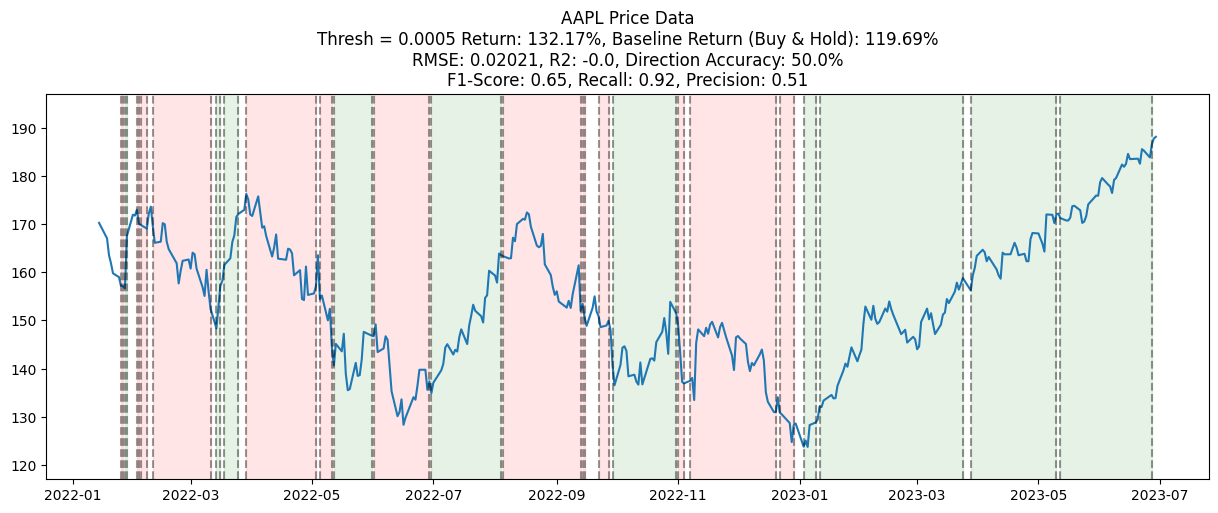

In [29]:
simulate(model, test_loader, df_test, historical_data['Close'], ticker_symbol, thresh=0.0005)

## Transformer

In [30]:
train_loader, test_loader = prepare_data(df_train, df_test, 'Return')

In [31]:
model = TransformerRegressor(input_dim=6, d_model=8, nhead=2, n_encoder_layers=1, dropout=0.1).to(device)
trainer = ModelTrainer(model, lr=0.001)
trainer.train(train_loader, test_loader, early_stop_threshold=5)

/home/user/Git/stock_price_prediction/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/user/Git/stock_price_prediction/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/1000, Validation Loss: 0.000403479, Return: 116.64$
Epoch 2/1000, Validation Loss: 0.000687610, Return: 90.93$
Epoch 3/1000, Validation Loss: 0.000437218, Return: 121.52$
Epoch 4/1000, Validation Loss: 0.000427092, Return: 99.51$
Epoch 5/1000, Validation Loss: 0.000450225, Return: 128.92$
Early stopping!


np.float64(0.0004034793018945493)

In [32]:
# torch.save(model, 'stock_transformer.pt')
# torch.save(model.state_dict(), 'stock_transformer_state_dict.pt')

In [33]:
model = torch.load('models/stock_transformer.pt')

/tmp/ipykernel_477384/1498100029.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/stock_transformer.pt')


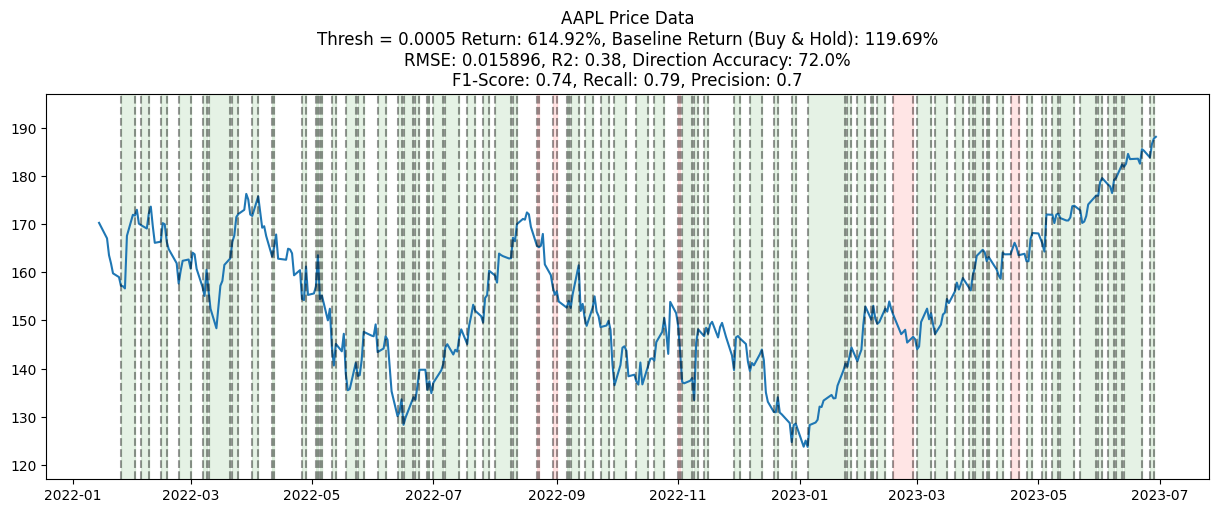

In [34]:
simulate(model, test_loader, df_test, historical_data['Close'], ticker_symbol, thresh=0.0005)

# Backtest

## LSTM

In [35]:
train_loader, test_loader = prepare_data(df_backtest_train, df_backtest_test, 'Return')

In [36]:
model = torch.load('models/stock_lstm.pt')

/tmp/ipykernel_477384/409919433.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/stock_lstm.pt')


In [37]:
trainer = ModelTrainer(model, lr=0.001)
trainer.train(train_loader, test_loader, epochs=30, early_stop_threshold=30)

/home/user/Git/stock_price_prediction/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30, Validation Loss: 0.000183513, Return: 100.0$
Epoch 2/30, Validation Loss: 0.000183046, Return: 100.0$
Epoch 3/30, Validation Loss: 0.000181788, Return: 100.0$
Epoch 4/30, Validation Loss: 0.000182995, Return: 100.0$
Epoch 5/30, Validation Loss: 0.000182564, Return: 100.0$
Epoch 6/30, Validation Loss: 0.000181178, Return: 100.0$
Epoch 7/30, Validation Loss: 0.000182307, Return: 100.0$
Epoch 8/30, Validation Loss: 0.000181788, Return: 100.0$
Epoch 9/30, Validation Loss: 0.000182391, Return: 100.0$
Epoch 10/30, Validation Loss: 0.000182122, Return: 100.0$
Epoch 11/30, Validation Loss: 0.000178876, Return: 100.0$
Epoch 12/30, Validation Loss: 0.000178827, Return: 100.0$
Epoch 13/30, Validation Loss: 0.000178762, Return: 100.0$
Epoch 14/30, Validation Loss: 0.000179020, Return: 100.0$
Epoch 15/30, Validation Loss: 0.000179282, Return: 100.0$
Epoch 16/30, Validation Loss: 0.000179141, Return: 100.0$
Epoch 17/30, Validation Loss: 0.000178787, Return: 100.0$
Epoch 18/30, Validation

np.float64(0.00017839016921546622)

In [38]:
# torch.save(model, 'stock_lstm_backtest.pt')
# torch.save(model.state_dict(), 'stock_lstm_state_dict_backtest.pt')

In [39]:
model = torch.load('models/stock_lstm_backtest.pt')

/tmp/ipykernel_477384/4160756352.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/stock_lstm_backtest.pt')


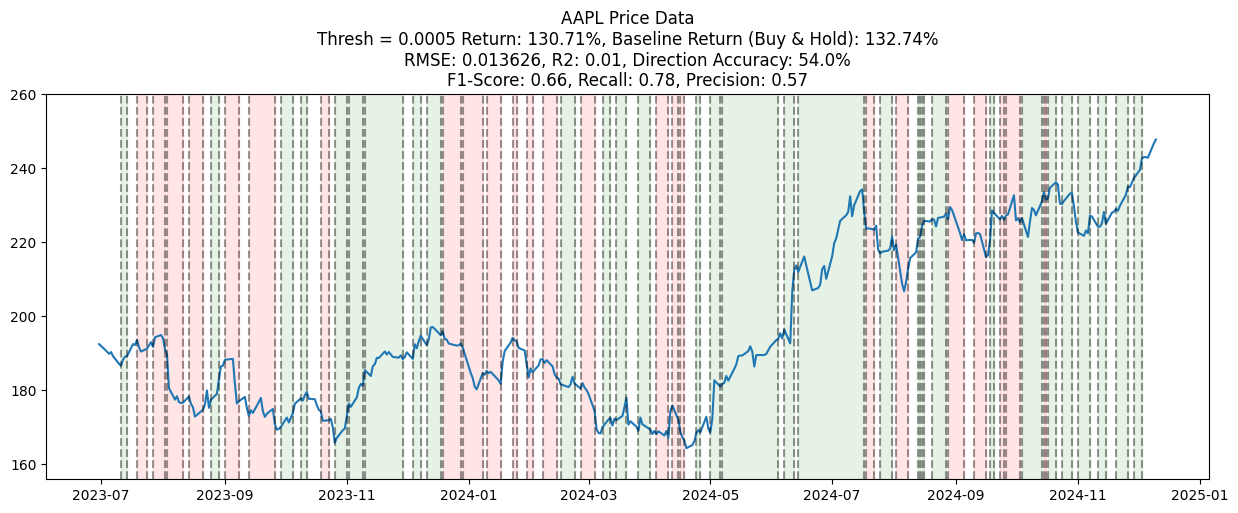

In [40]:
simulate(model, test_loader, df_backtest_test, historical_data['Close'], ticker_symbol, thresh=0.0005)

## Transformer

In [41]:
train_loader, test_loader = prepare_data(df_backtest_train, df_backtest_test, 'Return')

In [42]:
model = torch.load('models/stock_transformer.pt')

/tmp/ipykernel_477384/1498100029.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/stock_transformer.pt')


In [43]:
trainer = ModelTrainer(model, lr=0.001)
trainer.train(train_loader, test_loader, epochs=30, early_stop_threshold=30)

/home/user/Git/stock_price_prediction/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30, Validation Loss: 0.000116566, Return: 220.07$
Epoch 2/30, Validation Loss: 0.000113096, Return: 247.09$
Epoch 3/30, Validation Loss: 0.000111751, Return: 318.43$
Epoch 4/30, Validation Loss: 0.000109856, Return: 239.9$
Epoch 5/30, Validation Loss: 0.000108640, Return: 316.11$
Epoch 6/30, Validation Loss: 0.000113773, Return: 212.33$
Epoch 7/30, Validation Loss: 0.000106930, Return: 272.15$
Epoch 8/30, Validation Loss: 0.000110705, Return: 309.6$
Epoch 9/30, Validation Loss: 0.000109337, Return: 238.51$
Epoch 10/30, Validation Loss: 0.000105734, Return: 275.08$
Epoch 11/30, Validation Loss: 0.000110229, Return: 292.84$
Epoch 12/30, Validation Loss: 0.000109935, Return: 221.95$
Epoch 13/30, Validation Loss: 0.000110842, Return: 236.33$
Epoch 14/30, Validation Loss: 0.000106965, Return: 308.34$
Epoch 15/30, Validation Loss: 0.000106788, Return: 236.99$
Epoch 16/30, Validation Loss: 0.000105758, Return: 234.27$
Epoch 17/30, Validation Loss: 0.000105911, Return: 290.22$
Epoch 18

np.float64(0.00010188377700615092)

In [44]:
# torch.save(model, 'stock_transformer_backtest.pt')
# torch.save(model.state_dict(), 'stock_transformer_state_dict_backtest.pt')

In [45]:
model = torch.load('models/stock_transformer_backtest.pt')

/tmp/ipykernel_477384/3684998795.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/stock_transformer_backtest.pt')


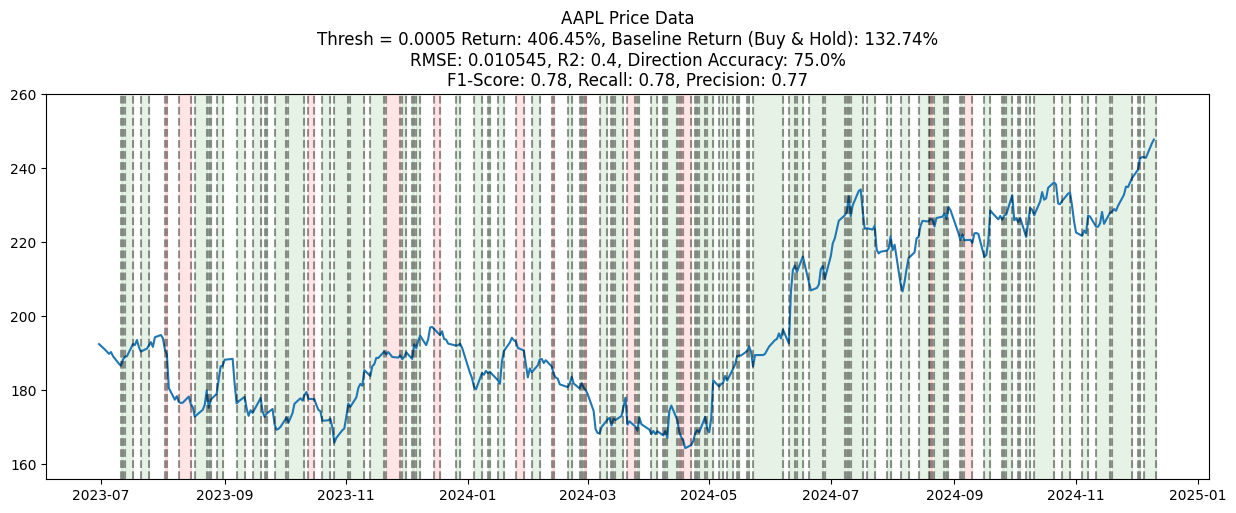

In [46]:
simulate(model, test_loader, df_backtest_test, historical_data['Close'], ticker_symbol, thresh=0.0005)